In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission_v2.csv', 'test-tif-v3', 'train-tif-v2', 'test-jpg-v2', 'test_v2_file_mapping.csv', 'train-jpg', 'train_v2.csv']


In [2]:
import fastai
fastai.__version__

'1.0.51'

In [3]:
from fastai.vision import *

## Multiclassification

Each image in this dataset is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv('../input/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a DataBunch while using the data block API, we then need to using ImageList (and not ImageDataBunch). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

In [6]:
np.random.seed(42)
src = (ImageList.from_csv('../input/', 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .split_by_rand_pct(0.2)
      .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size=228)
       .databunch().normalize(imagenet_stats))

show_batch still works and shows us the different labels separated by semicolon.

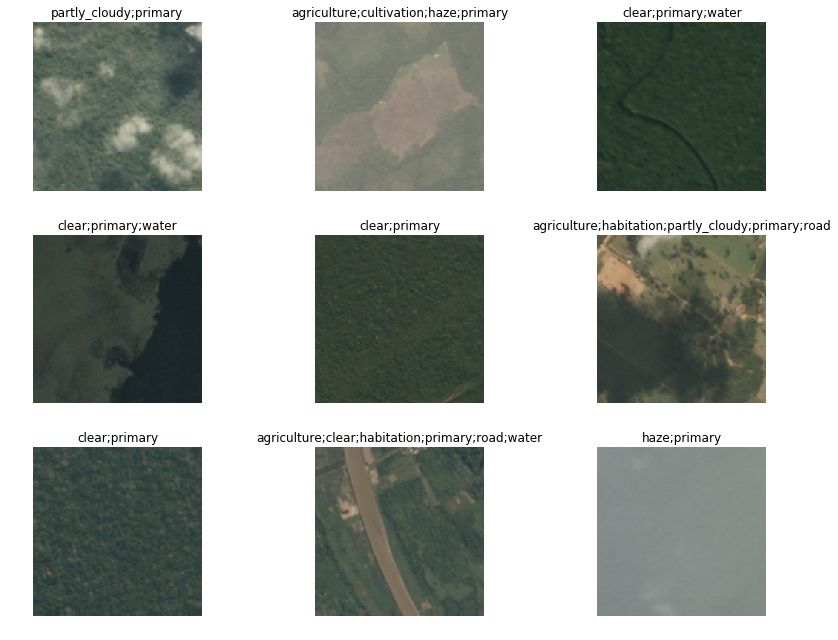

In [8]:
data.show_batch(rows=3, figsize=(12,9))

## Training the model

To create a Learner, we use the again ResNet-50, but the metrics are a little bit different. We use accuracy_thresh instead of accuracy. This new metric selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground-truth.

As for F-score, it's the metric that was used by Kaggle on this competition.

In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/model/')

We use the LR Finder to pick a good learning rate.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-rn50')

## Predicting for the competition

In [ ]:
test = ImageList.from_folder('../input/test-jpg-v2')
len(test)

In [ ]:
learn = load_learner('../tmp/model/', test=test)
preds = learn.get_preds(test)

In [ ]:
predictions = np.vstack((preds[0], preds[1]))
len(predictions)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in predictions]

In [ ]:
labelled_preds[:5]